In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import MDS
import numpy as np
from sklearn.metrics import euclidean_distances

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']

In [3]:
# Files definition
root_output_path = 'output'
comment_bow = root_output_path+"/cooc_bow_all.csv"
cooc_matrix_bow = pd.read_csv(comment_bow,index_col=0)
questionaire = root_output_path+"/Questionaires.xlsx"
questionaire_matrix = pd.read_excel(questionaire,index_col=0)

In [4]:
questionaire_matrix.head()

,เพศ,ช่วงอายุ,บุตร,จำนวนบุตร,ยี่ห้อ,เมจิ,ดัชมิลล์,โฟร์โมสต์,แดรี่โฮม,โชคชัย,...,ราคาคุ้มค่าเมื่อเทียบคุณค่าทางอาหาร,ราคาคุ้มค่าเมื่อเทียบปริมาณ,ผสมนมผง,ลูกไม่ยอมกินนม,เพิ่มความสูง,เพิ่มน้ำหนัก,ย่อยยาก ท้องอืด,พกพาง่าย,อายุเก็บรักษาสั้น,โรคกระเพาะ
ลำดับ,,,,,,,,,,,,,,,,,,,,,
A01,1,2,1,0,เมจิ,1,0,0,0,0,...,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A01,1,2,1,0,ดัชมิลล์,0,1,0,0,0,...,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A01,1,2,1,0,โฟร์โมสต์,0,0,1,0,0,...,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A01,1,2,1,0,แดรี่โฮม,0,0,0,1,0,...,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A01,1,2,1,0,โชคชัย,0,0,0,0,1,...,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Steps<br>
1. ตัดข้อมูลไม่สมบูรณ์ออก (2คน)
2. Clean missing data
3. EDA - เพศ อายุ คนมีบุตร
4. EDA - ยี่ห้อยอดนิยม
5. MDS เช็ค Stress
6. สร้าง Coocc-Matrix

In [5]:
brands = ['เมจิ','ดัชมิลล์','โฟร์โมสต์','แดรี่โฮม','โชคชัย','เอ็มมิลค์','ไทยเดนมาร์ค']

In [6]:
questionaire_matrix.drop('A14',axis=0,inplace=True)
questionaire_matrix.drop('A27',axis=0,inplace=True)

In [7]:
questionaire_matrix = questionaire_matrix.fillna(1)

In [8]:
df_personal = questionaire_matrix.iloc[:,0:4].reset_index()
df_personal.drop_duplicates(keep='last',inplace=True, ignore_index=True)

df_only_elements = questionaire_matrix.iloc[:,4:]

In [9]:
df_agg_sex = pd.DataFrame(df_personal.groupby('เพศ').size(),columns=['cnt']).T
df_agg_age = pd.DataFrame(df_personal.groupby('ช่วงอายุ').size(),columns=['cnt']).T
df_agg_child = pd.DataFrame(df_personal.groupby('บุตร').size(),columns=['cnt']).T
df_agg_childNum = pd.DataFrame(df_personal.groupby('จำนวนบุตร').size(),columns=['cnt']).T
df_brand_count = pd.DataFrame(df_only_elements.iloc[:,1:8].sum(),columns=['sum']).T

In [10]:
# 1 ชาย 2 หญิง
df_agg_sex

เพศ,1,2
cnt,6,26


In [11]:
# 2 = 21-30 ปี, 3 = 31-40 ปี, 4 = 41-50 ปี, 5 = 51 ปีขึ้นไป
df_agg_age

ช่วงอายุ,2,3,4,5
cnt,19,10,2,1


In [12]:
# 1 = ไม่มี, 2 = มี
df_agg_child

บุตร,1,2
cnt,23,9


In [13]:
# 0 ไม่มีุตร , 2 = 2 คน
df_agg_childNum

จำนวนบุตร,0,1,2
cnt,23,5,4


In [14]:
df_brand_count

,เมจิ,ดัชมิลล์,โฟร์โมสต์,แดรี่โฮม,โชคชัย,เอ็มมิลค์,ไทยเดนมาร์ค
sum,32,32,30,15,17,16,25


In [15]:
df_brands = df_only_elements.iloc[:,0:8]
df_brands.reset_index(inplace=True)
df_brands.set_index(['ยี่ห้อ','ลำดับ'],inplace=True)

df_elements = df_only_elements.drop(labels=brands,axis=1)

#### Normalization<br>
ดำเนินการทำ normalization อิง min-max รายยี่ห้อ 

In [16]:
df_min = df_elements.groupby(['ยี่ห้อ'], as_index=True).min()
df_max = df_elements.groupby(['ยี่ห้อ'], as_index=True).max()
#df_mad = df_elements.groupby(['ยี่ห้อ'], as_index=True).mad()

In [17]:
#df_mad.head(10)

In [18]:
df_elements.reset_index(inplace=True)
df_elements.set_index(['ยี่ห้อ','ลำดับ'],inplace=True)

In [19]:
# (Original - min) / (max-min)
df_norm = (df_elements.sort_values(['ยี่ห้อ','ลำดับ'],ascending=True).groupby('ยี่ห้อ').head(50)-df_min)/(df_max-df_min)

In [20]:
df_norm.reset_index(inplace=True)
df_norm.set_index(['ยี่ห้อ','ลำดับ'],inplace=True)

In [21]:
df_only_elements = pd.concat([df_brands,df_norm], axis=1,join='inner').reset_index('ยี่ห้อ',drop=True)

In [22]:
df_only_elements

,เมจิ,ดัชมิลล์,โฟร์โมสต์,แดรี่โฮม,โชคชัย,เอ็มมิลค์,ไทยเดนมาร์ค,ทำให้สูง,อิ่มท้อง,เสริมกระดูก,...,ราคาคุ้มค่าเมื่อเทียบคุณค่าทางอาหาร,ราคาคุ้มค่าเมื่อเทียบปริมาณ,ผสมนมผง,ลูกไม่ยอมกินนม,เพิ่มความสูง,เพิ่มน้ำหนัก,ย่อยยาก ท้องอืด,พกพาง่าย,อายุเก็บรักษาสั้น,โรคกระเพาะ
ลำดับ,,,,,,,,,,,,,,,,,,,,,
A01,1,0,0,0,0,0,0,0.333333,0.333333,1.000000,...,0.666667,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
A01,0,1,0,0,0,0,0,0.666667,0.666667,1.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
A01,0,0,1,0,0,0,0,1.000000,1.000000,1.000000,...,0.666667,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
A01,0,0,0,1,0,0,0,0.333333,1.000000,1.000000,...,0.666667,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
A01,0,0,0,0,1,0,0,1.000000,1.000000,1.000000,...,1.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A34,0,0,1,0,0,0,0,0.666667,0.333333,0.666667,...,0.000000,0.000000,0.333333,0.666667,1.000000,0.666667,0.333333,1.0,0.0,0.0
A34,0,0,0,1,0,0,0,0.000000,0.000000,0.000000,...,1.000000,0.666667,0.333333,0.666667,0.666667,1.000000,0.333333,1.0,0.0,0.0
A34,0,0,0,0,1,0,0,0.000000,0.000000,0.000000,...,1.000000,0.666667,1.000000,1.000000,1.000000,1.000000,0.333333,1.0,1.0,0.0


#### Jaccard Similarity converter 

In [23]:
def jaccard_precompute(df_b, df_elem , bi, bj, ek):
    brand1 = df_elem[df_elem[df_b[bi]]>0].drop(labels=df_b,axis=1)
    brand2 = df_elem[df_elem[df_b[bj]]>0].drop(labels=df_b,axis=1)
    slice_df = pd.concat([brand1.iloc[:,ek], brand2.iloc[:,ek]], axis=1, join="inner")
    a_in_b = slice_df[(slice_df.iloc[:,0]==slice_df.iloc[:,1])].shape[0]
    a_occur = slice_df.iloc[:,0].shape[0]
    b_occur = slice_df.iloc[:,1].shape[0]
    jacc_index = a_in_b/(a_occur+b_occur-a_in_b)
    return jacc_index

In [24]:
# Co-occurrence dissimilarity (distance = 1-index) ใช้กับ MDS (อย่าใช้ similarity)
def gen_precomputed_Distance_matrix(df_b, df_attr):
    precomputed_matrix = pd.DataFrame(index=df_b,columns=df_b).fillna(0)
    
    jacc = pd.DataFrame(columns=df_attr.drop(labels=df_b,axis=1).columns)
    jacc = jacc.append(pd.Series([],dtype='float64'), ignore_index=True).fillna(0.0)
    
    for i in range(0,len(precomputed_matrix.columns)):
        for j in range(0,len(precomputed_matrix.columns)):
            #print(i,j)
            for k in range(0,len(df_attr.drop(labels=df_b,axis=1).columns)): # 0 to 57
                try:
                    jacc.iloc[0,k] = 1-jaccard_precompute(df_b, df_attr,i, j, k)
                except Exception:
                    jacc.iloc[0,k] = None
                    continue
            precomputed_matrix.iloc[i,j] = jacc.mean(axis=1)[0]
            jacc = jacc.iloc[0:0].append(pd.Series([],dtype='float64'), ignore_index=True).fillna(0.0)
    return precomputed_matrix

In [25]:
#jacc_cooc_matrix = gen_precomputed_matrix(brands, df_only_elements)
jacc_dist_matrix = gen_precomputed_Distance_matrix(brands, df_only_elements)

In [26]:
jacc_dist_matrix

,เมจิ,ดัชมิลล์,โฟร์โมสต์,แดรี่โฮม,โชคชัย,เอ็มมิลค์,ไทยเดนมาร์ค
เมจิ,0.000000,0.203588,0.240660,0.456619,0.345406,0.441060,0.322663
ดัชมิลล์,0.203588,0.000000,0.182184,0.440439,0.325419,0.477393,0.327771
โฟร์โมสต์,0.240660,0.182184,0.000000,0.472340,0.327422,0.470493,0.312053
แดรี่โฮม,0.456619,0.440439,0.472340,0.000000,0.265785,0.337279,0.400265
โชคชัย,0.345406,0.325419,0.327422,0.265785,0.000000,0.339188,0.233218
เอ็มมิลค์,0.441060,0.477393,0.470493,0.337279,0.339188,0.000000,0.406385
ไทยเดนมาร์ค,0.322663,0.327771,0.312053,0.400265,0.233218,0.406385,0.000000


In [27]:
jacc_dist_matrix.to_excel(root_output_path+"/cooc_questionaire.xlsx")

#### Jaccard from NLP

In [28]:
def jaccard_precompute_nlp(df_b, df_attr , i, j, k):
    brand1 = pd.DataFrame(df_b.iloc[:,i])
    brand2 = pd.DataFrame(df_b.iloc[:,j])
    attr = pd.DataFrame(df_attr.iloc[:,k])
    slice_df = pd.concat([brand1, attr, brand2], axis=1, join="inner")
    a_in_b = slice_df[(slice_df.iloc[:,0]>0)&(slice_df.iloc[:,1]>0)&(slice_df.iloc[:,2]>0)]
    a_occur = slice_df[(slice_df.iloc[:,0]>0)&(slice_df.iloc[:,1]>0)]
    b_occur = slice_df[(slice_df.iloc[:,2]>0)&(slice_df.iloc[:,1]>0)]
    jacc_index = a_in_b.shape[0]/(a_occur.shape[0]+b_occur.shape[0]-a_in_b.shape[0])
    return jacc_index

In [29]:
# Co-occurrence dissimilarity (distance = 1-index) ใช้กับ MDS (อย่าใช้ similarity)
def gen_precomputed_matrix_nlp(df_b, df_attr):
    precomputed_matrix = pd.DataFrame(index=df_b.columns,columns=df_b.columns).fillna(0)
    
    jacc = pd.DataFrame(columns=df_attr.columns)
    jacc = jacc.append(pd.Series([],dtype='float64'), ignore_index=True).fillna(0.0)
    
    for i in range(0,len(precomputed_matrix.columns)):
        for j in range(0,len(precomputed_matrix.columns)):
            for k in range(0,len(df_attr.columns)): # 0 to 329
                try:
                    jacc.iloc[0,k] = 1-jaccard_precompute_nlp(df_b, df_attr,i, j, k)
                except Exception:
                    jacc.iloc[0,k] = None
                    continue
            precomputed_matrix.iloc[i,j] = jacc.mean(axis=1)[0]
            jacc = jacc.iloc[0:0].append(pd.Series([],dtype='float64'), ignore_index=True).fillna(0.0)
    return precomputed_matrix

In [30]:
matrix_freq_brand = cooc_matrix_bow[brands]
matrix_freq_unbrand = cooc_matrix_bow.drop(labels=brands,axis=1,inplace=False)

In [31]:
precomMat_promotion = gen_precomputed_matrix_nlp(matrix_freq_brand, matrix_freq_unbrand)

In [32]:
precomMat_promotion

,เมจิ,ดัชมิลล์,โฟร์โมสต์,แดรี่โฮม,โชคชัย,เอ็มมิลค์,ไทยเดนมาร์ค
เมจิ,0.000000,0.889197,0.905533,0.980437,0.970354,0.959829,0.949960
ดัชมิลล์,0.889197,0.000000,0.875328,0.978107,0.958265,0.999545,0.888589
โฟร์โมสต์,0.905533,0.875328,0.000000,1.000000,0.964530,0.999742,0.882579
แดรี่โฮม,0.980437,0.978107,1.000000,0.000000,0.986536,0.996212,0.957340
โชคชัย,0.970354,0.958265,0.964530,0.986536,0.000000,1.000000,0.975124
เอ็มมิลค์,0.959829,0.999545,0.999742,0.996212,1.000000,0.000000,0.999952
ไทยเดนมาร์ค,0.949960,0.888589,0.882579,0.957340,0.975124,0.999952,0.000000


In [33]:
precomMat_promotion.to_excel(root_output_path+"/cooc_nlp_crossValid.xlsx")

#### Check MDS Stress: Metric multidimensional scaling (mMDS)<br>
เหตุผลที่ใช้ Metric เพราะว่าเราใช้ Jaccard Distance สร้าง Square Matrix ทำให้ข้อมูลไม่กลายเป็น Rank

In [34]:
# REF: https://stackoverflow.com/questions/36428205/stress-attribute-sklearn-manifold-mds-python
# REF2: http://eric.univ-lyon2.fr/~ricco/tanagra/fichiers/fr_Tanagra_Community_Detection_MDS.pdf

In [35]:
def create_MDS_perceptual_map(model, df, attrName):
    fig, ax=plt.subplots(figsize=(10,5))
    ax.set_title(f'MDS Perceptual map: {attrName}', fontsize=20)
    plt.scatter(model.embedding_[:,0],model.embedding_[:,1])
    labels=df.index
    for label,x,y in zip(labels, model.embedding_[:,0],model.embedding_[:,1]):
        plt.annotate(label,(x,y), fontsize=13)
    plt.axhline(y=0, color='k', linestyle='-', linewidth=1)
    plt.axvline(x=0, color='k', linestyle='-', linewidth=1)
    plt.xlabel('PC1', fontsize=16)
    plt.ylabel('PC2', fontsize=16)
    plt.grid(True)
    plt.show()

In [36]:
mds = MDS(n_components=2, dissimilarity='precomputed', metric=True)
mds.fit(jacc_dist_matrix)

MDS(dissimilarity='precomputed', eps=0.001, max_iter=300, metric=True,
    n_components=2, n_init=4, n_jobs=None, random_state=None, verbose=0)

In [37]:
## sklearn Stress
print("sklearn stress :")
print(mds.stress_)
print("")

sklearn stress :
0.07640536095875688



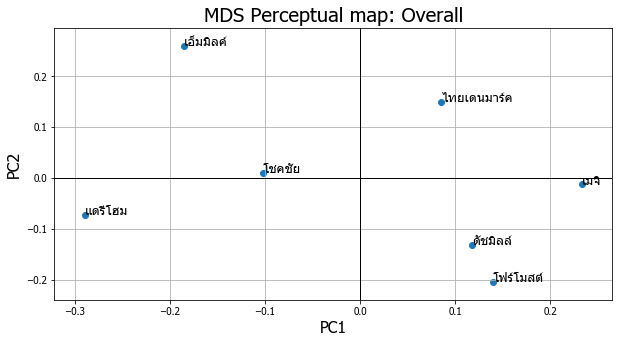

In [38]:
create_MDS_perceptual_map(mds, jacc_dist_matrix, 'Overall')

In [39]:
d = euclidean_distances(mds.embedding_)
stress = 0.5 * np.sum((jacc_dist_matrix.values - d)**2)
print("Raw stress :",stress)
print()
print("****จะเห็นว่าค่าใกล้เคียงกันกับ mds.stress_")

Raw stress : 0.07550006715832788

****จะเห็นว่าค่าใกล้เคียงกันกับ mds.stress_


In [40]:
## Kruskal's stress (or stress formula 1)
stress1 = np.sqrt(np.sum((jacc_dist_matrix.values - d)**2) / np.sum(d**2))
print("Kruskal's Stress :",stress1)

Kruskal's Stress : 0.16890138619956446
